In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import correlate
import seaborn as sns
from cmap import Colormap

import torch

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

In [4]:
from enum import Enum

class Label(Enum):
    DEEP_BREATH = 0
    DRY_COUGH = 1
    JUMPING_JACK = 2
    PUSH_UP = 3
    SWALLOWING = 4
    THROAT_CLEARING = 5

In [5]:
class BaseLHMDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
class LHMMonoDataset(BaseLHMDataset):
    def __getitem__(self, idx):
        return self.features[idx, ...].transpose(0, 1).float(), self.labels[idx]

loader = torch.load('../../../dataset/preprocessed/mono_alt.pt')
samples = []
labels = []

for sample, label in loader:
    samples.append(sample.numpy())
    labels.append(label.numpy())

samples = np.array(samples)
labels = np.array(labels)

db_m = samples[np.where(labels == Label.DEEP_BREATH.value)[0], :, :]
dc_m = samples[np.where(labels == Label.DRY_COUGH.value)[0], :, :]
tc_m = samples[np.where(labels == Label.THROAT_CLEARING.value)[0], :, :]
sw_m = samples[np.where(labels == Label.SWALLOWING.value)[0], :, :]

In [6]:
data = pd.read_csv('../interpolated.csv', delimiter=',', header=None).to_numpy()
frames = data[:, 0]
c = data[:, 1]
b = data[:, 2]

discontinuities = np.where(np.diff(frames) != 1)[0] + 1
frame_sections = np.split(frames, discontinuities)
c_sections = np.split(c, discontinuities)
b_sections = np.split(b, discontinuities)

db_mc = np.column_stack((c_sections[0], b_sections[0]))
dc_mc = np.column_stack((c_sections[1], b_sections[1]))
tc_mc = np.column_stack((c_sections[2], b_sections[2]))
sw_mc = np.column_stack((c_sections[3], b_sections[3]))

db_me = np.mean(db_m[:, :, :2], axis=0)
dc_me = np.mean(dc_m[:, :, :2], axis=0)
tc_me = np.mean(tc_m[:, :, :2], axis=0)
sw_me = np.mean(sw_m[:, :, :2], axis=0)

In [56]:
class SignalComparison:
    def __init__(self, sig_mc, sig_me):
        self.sig_mc = sig_mc
        self.sig_me = sig_me
        self.central_mc, self.bottom_mc = sig_mc[:, 0], sig_mc[:, 1]
        self.central_me, self.bottom_me = sig_me[:, 0], sig_me[:, 1]

    def normalize(self, x):
        return (x - np.mean(x)) / np.std(x)

    def find_best_match(self, sig_me, sig_mc):
        window_size = len(sig_mc)
        actual_length = len(sig_me)
        max_corr = -1
        best_pos = 0

        for i in range(actual_length - window_size + 1):
            window_me = sig_me[i: i + window_size]
            norm_window_me = self.normalize(window_me)
            norm_window_mc = self.normalize(sig_mc)
            corr = np.max(correlate(norm_window_me, norm_window_mc))

            if corr > max_corr:
                max_corr = corr
                best_pos = i

        return sig_me[best_pos: best_pos + window_size], max_corr

    def estimate_scaling_factor(self, sig_me, sig_mc):
        return np.sum(sig_me * sig_mc) / np.sum(sig_mc ** 2)
    
    def plot_cross_correlation(self, central_best_match, central_scaled_mc, bottom_best_match, bottom_scaled_mc):
        min_length_central = min(len(central_best_match), len(central_scaled_mc))
        central_best_match = central_best_match[:min_length_central]
        central_scaled_mc = central_scaled_mc[:min_length_central]

        min_length_bottom = min(len(bottom_best_match), len(bottom_scaled_mc))
        bottom_best_match = bottom_best_match[:min_length_bottom]
        bottom_scaled_mc = bottom_scaled_mc[:min_length_bottom]

        # Normalize the signals
        normalized_central_me = self.normalize(central_best_match)
        normalized_central_mc = self.normalize(central_scaled_mc)
        normalized_bottom_me = self.normalize(bottom_best_match)
        normalized_bottom_mc = self.normalize(bottom_scaled_mc)

        corr_central = correlate(normalized_central_me,
                                 normalized_central_mc, mode='same') / min_length_central
        corr_bottom = correlate(normalized_bottom_me,
                                normalized_bottom_mc, mode='same') / min_length_bottom
        lags_central = np.arange(-min_length_central//2, min_length_central//2)
        lags_bottom = np.arange(-min_length_bottom//2, min_length_bottom//2)

        self.fig, self.ax = plt.subplots(figsize=(6, 2))
        self.ax.plot(lags_central, corr_central, label='central')
        self.ax.plot(lags_bottom, corr_bottom, label='bottom')
        self.ax.set_xlim(-20, 20)
        self.ax.set_ylim(-0.2, 1)
        self.ax.set_xlabel('Lag')
        self.ax.set_ylabel('Cross-correlation')
        self.ax.legend(loc='upper left', frameon=False)
    
    def compare_signals(self):
        central_best_match, central_max_corr = self.find_best_match(self.central_me, self.central_mc)
        bottom_best_match, bottom_max_corr = self.find_best_match(self.bottom_me, self.bottom_mc)

        central_scaling_factor = self.estimate_scaling_factor(central_best_match, self.central_mc)
        bottom_scaling_factor = self.estimate_scaling_factor(bottom_best_match, self.bottom_mc)

        central_scaled_mc = central_scaling_factor * self.central_mc
        bottom_scaled_mc = bottom_scaling_factor * self.bottom_mc

        # Compute normalized cross-correlation at zero lag
        central_corr_at_zero_lag = np.max(np.correlate(self.normalize(central_best_match),
                                                       self.normalize(central_scaled_mc), mode='same') / len(central_best_match))
        bottom_corr_at_zero_lag = np.max(np.correlate(self.normalize(bottom_best_match),
                                                      self.normalize(bottom_scaled_mc), mode='same') / len(bottom_best_match))

        self.plot_cross_correlation(central_best_match, central_scaled_mc, bottom_best_match, bottom_scaled_mc)

        return {
            "central": {
                "scaling_factor": central_scaling_factor,
                "corr_at_zero_lag": central_corr_at_zero_lag
            },
            "bottom": {
                "scaling_factor": bottom_scaling_factor,
                "corr_at_zero_lag": bottom_corr_at_zero_lag
            }
        }

Central channel:
Corr after scaling: 0.7745255862752864
Scaling factor: 0.07834363316215803

Bottom channel:
Corr after scaling: 0.7945461376779799
Scaling factor: 0.08662982356860213


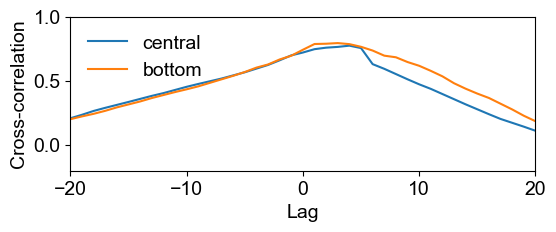

In [57]:
comparison = SignalComparison(db_mc, db_me)
results = comparison.compare_signals()
comparison.fig.savefig('deep breath.png', dpi=600, bbox_inches='tight')

print("Central channel:")
print("Corr after scaling:", results["central"]["corr_at_zero_lag"])
print("Scaling factor:", results["central"]["scaling_factor"])

print("\nBottom channel:")
print("Corr after scaling:", results["bottom"]["corr_at_zero_lag"])
print("Scaling factor:", results["bottom"]["scaling_factor"])

Central channel:
Corr after scaling: 0.8035562253041914
Scaling factor: 1.2642423407557903e-05

Bottom channel:
Corr after scaling: 0.28614081924333357
Scaling factor: 0.08689892385902127


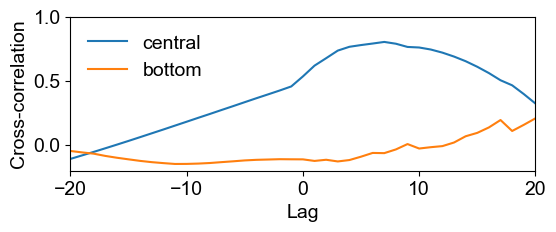

In [58]:
comparison = SignalComparison(dc_mc, dc_me)
results = comparison.compare_signals()
plt.savefig('dry cough.png', dpi=600, bbox_inches='tight')

print("Central channel:")
print("Corr after scaling:", results["central"]["corr_at_zero_lag"])
print("Scaling factor:", results["central"]["scaling_factor"])

print("\nBottom channel:")
print("Corr after scaling:", results["bottom"]["corr_at_zero_lag"])
print("Scaling factor:", results["bottom"]["scaling_factor"])

Central channel:
Corr after scaling: 0.7476554464693865
Scaling factor: 0.030868343013136908

Bottom channel:
Corr after scaling: 0.3557826083811645
Scaling factor: 0.08258899463337604


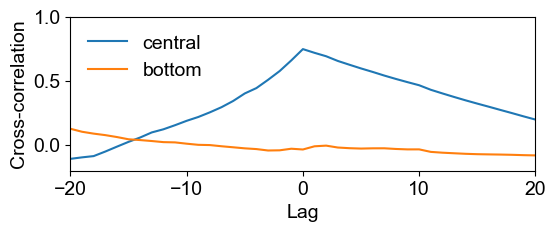

In [59]:
comparison = SignalComparison(tc_mc, tc_me)
results = comparison.compare_signals()
plt.savefig('throat clearing.png', dpi=600, bbox_inches='tight')

print("Central channel:")
print("Corr after scaling:", results["central"]["corr_at_zero_lag"])
print("Scaling factor:", results["central"]["scaling_factor"])

print("\nBottom channel:")
print("Corr after scaling:", results["bottom"]["corr_at_zero_lag"])
print("Scaling factor:", results["bottom"]["scaling_factor"])

Central channel:
Corr after scaling: 0.628288933430538
Scaling factor: 0.10091554562138777

Bottom channel:
Corr after scaling: 0.502849379661522
Scaling factor: 0.0004998005114808897


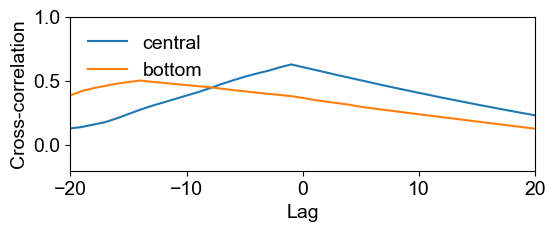

In [60]:
comparison = SignalComparison(sw_mc, sw_me)
results = comparison.compare_signals()
plt.savefig('swallowing.png', dpi=600, bbox_inches='tight')

print("Central channel:")
print("Corr after scaling:", results["central"]["corr_at_zero_lag"])
print("Scaling factor:", results["central"]["scaling_factor"])

print("\nBottom channel:")
print("Corr after scaling:", results["bottom"]["corr_at_zero_lag"])
print("Scaling factor:", results["bottom"]["scaling_factor"])